# LVM Data Simulator tutorial

This is a tutorial to install and use the LVM Data Simulator - Created 2022/03/24

## Installation and setup

### Installing the package

The package can be found on github at this link: https://github.com/sdss/lvmdatasimulator

First clone the package with:

```git clone --recursive https://github.com/sdss/lvmdatasimulator```
    
then move into the package directory and install it with ```python -m pip install -e .```. Pip should automatically install all the dependencies needed for the simulator to work (if not, let us know!)

### Downloading libraries

Once the package is installed, you have to download two files that are temporarily stored in an FTP serer at Universidad de Chile.

To download them you should run the following commands and move the files in the ```lvmdatasimulator/data``` directory:

```wget ftp@ftp.das.uchile.cl:/pub/enrico/LVM_cloudy_sphere_models.fits```

```wget ftp@ftp.das.uchile.cl:/pub/enrico/pollux_resampled_v0.fits```

At this point, everything should be ready to go. We just want to highlight that this is still a work-in-progress, and in the future how the simulator is called could change significantly. The goal is to write a main.py script able to read a configuration file.

## Part 1: simulating the target field

The first step to perform the simulations is to create a field to be observed. Once the field is created, all its components can be saved to fits files and used again in future runs.

We first need to import all the necessary modules needed for the simulations:

In [ ]:
import astropy.units as u
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

[WARNING]: Pre-computed models of continuum are not available. 


Then, we need to setup the LVM field object:

In [ ]:
my_lvmfield = LVMField(ra=10, dec=-10, size=15, spaxel=1, unit_ra=u.degree,
                       unit_dec=u.degree, unit_size=u.arcmin, unit_spaxel=u.arcsec, name='LVM_test')

This line initializes the LVMField object. The needed inputs are:
- ra, dec: coordinates of the field to be observed. Used to build the WCS object
- size: size of the field to simulate
- spaxel: size of the spaxel
- unit_ra, unit_dec: unit used for the coordinates of the field, defaults to degrees
- unit size: unit of the size argument. defaults to arcmin
- unit_spaxel: unit of the spaxels, defaults to arcsec
- name: name of the field. It will be used to define the names of the output files.

It must be noticed that the size of the field now is only 15 armin. At this point, simulating the full LVM FOV is still not possible, unless the simulator is running on a computer with significant amounts of RAM (> 30 GB, but actual minimum limit not determined yet).

The object is still empty, we need to generate the targets of the simulations. There are two types iof targets that can be simulated: **stars** and **nebulae**.

**Stars** are simulated by searching the GAIA catalog for stars brighter than a user defined limit. To each star we associate a spectrum, based on the estimated temperature of the object. All spectra are recovered from the pollux spectral library. **The library is missing spectra with temperature between xxxx and xxxx degrees. Stellar spectra should only be used for signal-to-noise ratio estimates, not to recover physical quantities**.

The stellar component is created as following:

In [ ]:
my_lvmfield.generate_gaia_stars(gmag_limit=18)

Once created, the star list is automatically saved to file, and it can be used to re-run the simulation without having to query GAIA again. The default position of this file is the current working directory, but it can be saved in another position by defining the *directory* argument. To read the saved file:

In [ ]:
my_lvmfield.generate_gaia_stars(filename='LVM_test_starlist.fits.gz', directory='./')

[INFO]: Reading the star list from file ./LVM_test_starlist.fits.gz


The nebular component, on the other hand, contains a wide variety of different types of sources that can be created. While there are some core quantities shared among most types of sources, many need some type-specific keywords to be defined. For a complete view of the inputs needed for each kind of nebula, we refer to the code documentation.

The nebular component should be passed to the field object as a list of dictionaries. Each dictionary represent a single nebula. A simple example, where we simulate a bubble + a diffuse gas component, can be found here:

In [ ]:
my_nebulae = [
              {"type": 'Bubble', 'expansion_velocity': 10 * u.km/u.s,
               'turbulent_sigma': 20 * u.km/u.s,
               'radius': 15 * u.pc,
               'max_brightness': 1e-16 * u.erg / u.cm**2 / u.s / u.arcsec ** 2,
               'RA': '00h39m40s', 'DEC': "-10d02m13s",
               'cloudy_params': {'Z': 0.6, 'qH': 49., 'nH': 30, 'Teff': 30000, 'Rin': 0},
               'perturb_amplitude': 0.4, 'perturb_order': 8},
              {"type": 'DIG', 'max_brightness': 1e-17 * u.erg / u.cm ** 2 / u.s / u.arcsec ** 2,
               'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc}
              ]

To include the nebulae in the LVMField object we can use:

In [ ]:
my_lvmfield.add_nebulae(my_nebulae, save_nebulae="./testneb_v3.fits")

The nebulae will be saved to file, so that they can be reused for other simulations without having to generate them. To read the nebulae from file:

In [ ]:
my_lvmfield.add_nebulae(load_from_file="./testneb_v3.fits")

[INFO]: Nebulae successfully loaded from file


 ## Part 2: Setting up the simulator


At this point the Field is ready to be observed. We are still missing, however, the complete instrument setup. The instrument is composed by a **telescope**, a **spectrograph** and a **fiber bundle**. To create the elements we just need to generate the objects as follows:

In [ ]:
tel = LVM160()
spec = LinearSpectrograph()
bundle = FiberBundle(bundle_name='central', nrings=4, angle=0, custom_fibers=None)

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using only the central fiber.
[INFO]: Using the inner 4 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


So far, we support a single telescope object LVM160() and a single spectrograph configuration LinearSpectrograph(). The latter, in particular, is a spectrograph with a 3650-9800 A wavelength range, and a constant 0.5 A dispersion.

The fiber bundle, on the other hand is already pretty configurable. The array is built as a series of concentric hexagonal rings, and within the ring each fiber has a unique ID. Using therefore two numbers (the ring number and the fiber position) it is possible to univocally identify each fiber. Using this identification system it is possible to build a wide variety of fiber configurations. The one supported so far are:
- central: simulate only the central fiber
- full: simulate the full hexagonal array
- horizontal: simulate an horizontal line of fibers
- diagonals: simulate the main diagonals of the hexagons

the nrings argument can be used to limit how many fiber are going to be simulated. In particular, if nrings is not none, each different configuration except for "central" is simulated up to the fibers included in the hexagonal ring nrings.  

Here we there is an example of a "full" bundle with nrings=5

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 5 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


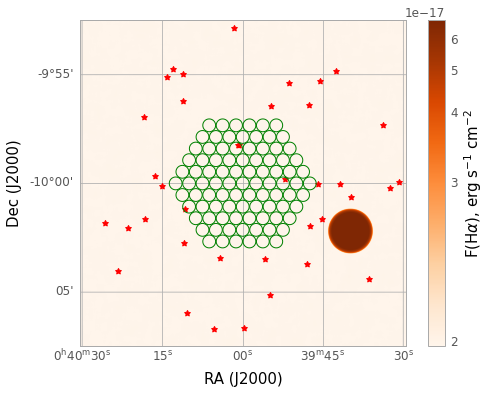

In [ ]:
bundle = FiberBundle(bundle_name='full', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./full_5.png')


Then, we have an example of a "diagonals" array with nrings=5 and nrings=9

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 5 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


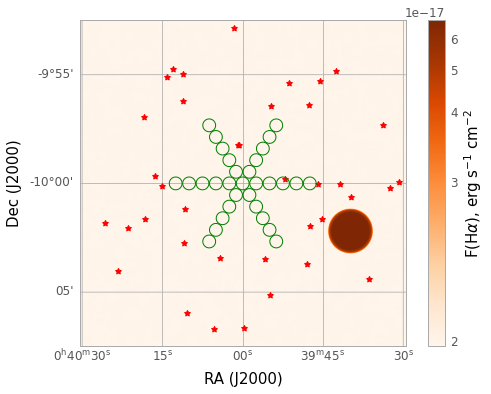

In [ ]:
bundle = FiberBundle(bundle_name='diagonals', nrings=5, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./diagonals_5.png')

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 9 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


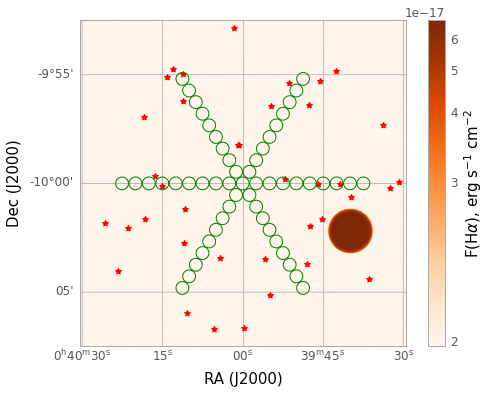

In [ ]:
bundle = FiberBundle(bundle_name='diagonals', nrings=9, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./diagonals_9.png')

Finally, an example of an "horizontal" array

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 0 deg.


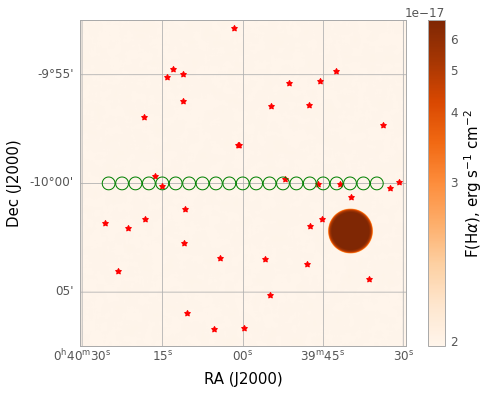

In [ ]:
bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=0, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./horizontal_10.png')

Fiber bundles can also be rotatet with the "angle" argument. The rotations proceeds counter clockwise. 

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 45 deg.


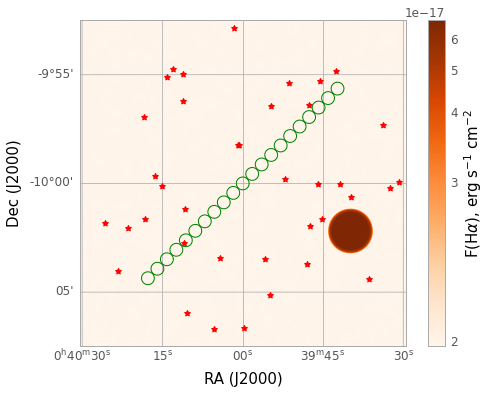

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using an horizontal line of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 90 deg.


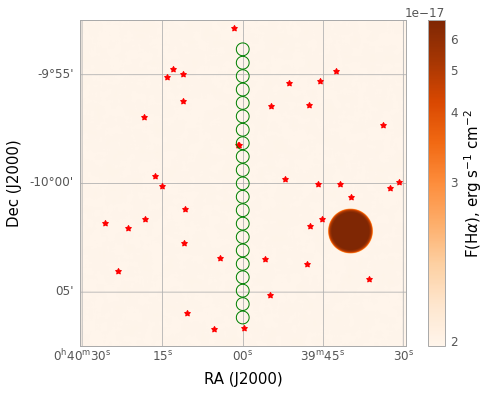

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using a diagonal pattern of fibers.
[INFO]: Using the inner 10 exagonal rings.
[INFO]: Rotating the bundle to PA = 90 deg.


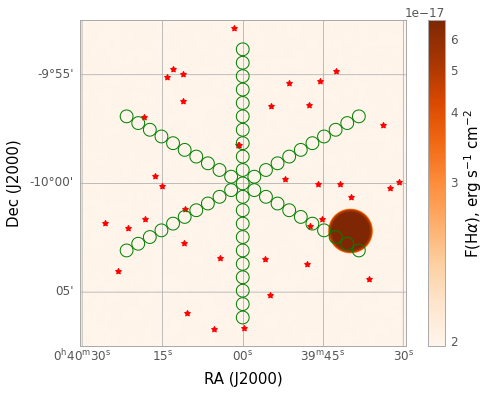

In [ ]:
bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=45, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./horizontal_10_45.png')

bundle = FiberBundle(bundle_name='horizontal', nrings=10, angle=90, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./horizontal_10_90.png')

bundle = FiberBundle(bundle_name='diagonals', nrings=10, angle=90, custom_fibers=None)
my_lvmfield.show(fibers=bundle.fibers, outname='./diagonals_10_90.png')

The last step before running the simulator is to define the properties of the observations by initializing the **Observation** object. This object requires the coordinates of the field to be observed, the exposure time, and, optionally, the date of the observation. The date and time of the observation, together with the coordinates of the object, will be used to determine the airmass of the observation and the lunar phase.

In [ ]:
obs = Observation(ra=10 * u.deg, dec=-10 * u.deg, exptime=24*900*u.s)

## Part 3: running the simulator

Now we are ready to perform the simulation. First we initialize the simulator, giving it as an input all the things we already initialized:

In [ ]:
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)

Them we can perform the simulations and save the outputs:

In [ ]:
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(6550 * u.AA, 6570 * u.AA)